<a href="https://colab.research.google.com/github/AdrienHdz/Deep_Learning_HEC/blob/master/Classification_with_BERT_%26_Graphs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction:
In this homework I used several deep learning models in order to perform classification with 5 labels of scientific research papers. 
* Firstly, I will show my Bert for sequence classification model with Pytorch and the huggingface library. 
* Then, I will go through different graph deep learning models with the package Stellargraph.

# We load the **librairies**

In [ ]:
!pip install transformers
import pandas as pd
import numpy as np
import random

import pandas as pd
import numpy as np
import os
import random
import networkx as nx

from tensorflow import keras

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

In [ ]:
import torch

# We tell pytorch we want to use Google Colab's GPU
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

We will use the GPU: Tesla P100-PCIE-16GB


# We load the data from google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
data_dic = {};
for dirname, _, filenames in os.walk('/content/drive/My Drive/Colab Notebooks'):
    for filename in filenames:
        if ".csv" in filename:
          data_dic[filename.split('.')[0]] = pd.read_csv(os.path.join(dirname, filename),index_col="id");

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_dic

{'reference':         id.1
 id          
 0      22305
 0      22491
 1       9243
 1      10943
 1      14322
 ...      ...
 25557  22946
 25558   8691
 25558  21420
 25560   3168
 25560   6353
 
 [73313 rows x 1 columns], 'sample':        label
 id          
 1          2
 2          0
 4          3
 5          3
 7          4
 ...      ...
 25553      4
 25556      1
 25558      4
 25559      3
 25560      2
 
 [12782 rows x 1 columns], 'test': Empty DataFrame
 Columns: []
 Index: [1, 2, 4, 5, 7, 10, 12, 14, 15, 16, 17, 19, 21, 22, 23, 25, 26, 27, 28, 29, 34, 35, 37, 39, 42, 45, 47, 49, 50, 51, 52, 57, 60, 61, 63, 64, 65, 66, 67, 70, 72, 73, 74, 76, 80, 83, 84, 85, 88, 89, 96, 100, 102, 104, 105, 109, 111, 117, 118, 121, 124, 125, 126, 127, 128, 129, 130, 131, 135, 136, 138, 139, 143, 148, 149, 150, 151, 154, 157, 158, 160, 161, 163, 164, 165, 166, 168, 171, 175, 176, 179, 181, 182, 183, 184, 186, 187, 191, 192, 193, ...]
 
 [12782 rows x 0 columns], 'text':                         

# BERT for Sequence Classification
My code has been adapted from Chris McCormick and Nick Ryan BERT Fine-Tuning tutorial:
https://colab.research.google.com/drive/1Y4o3jh3ZH70tl6mCd76vz_IxX23biCPP

In [ ]:
# We merge the data from train and text into a new DataFrame called df with 3 columns: id, label and title.
train = pd.DataFrame(data_dic["train"])
text = pd.DataFrame(data_dic["text"])
df = pd.merge(train, text, on=["id"])

print('Number of observations: {:,}\n'.format(df.shape[0]))

df.head(5)

Number of observations: 12,779



,label,title
id,,
0,1,interactive visual exploration of neighbor bas...
3,1,relational division four algorithms and their ...
6,1,simplifying xml schema effortless handling of ...
8,0,funbase a function based information managemen...
9,0,inverted matrix efficient discovery of frequen...


In [ ]:
# Then we extract the research papers labels and titles as numpy arrays.
titles = df.title.values
labels = df.label.values

# Tokenization

In [ ]:
# For Bert, we have to tokenize our text using the function BertTokenizer from the package transformers
# Here, we use the best-base-uncased pretrained model, a list of bert models for the package transformers can be found here https://huggingface.co/transformers/pretrained_models.html
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [ ]:
# Let's visualize the tokenization
print('Original sentence: ', titles[0])
print('Tokenized sentence: ', tokenizer.tokenize(titles[0]))
print('Tokens IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(titles[0])))

Original sentence:  interactive visual exploration of neighbor based patterns in data streams
Tokenized sentence:  ['interactive', 'visual', 'exploration', 'of', 'neighbor', 'based', 'patterns', 'in', 'data', 'streams']
Tokens IDs:  [9123, 5107, 8993, 1997, 11429, 2241, 7060, 1999, 2951, 9199]


In [ ]:
# We apply the tokenization for all the sentences
# We will save all the tokens IDs into a dictionnary called inputs_id
inputs_id = []

# The function tokenizer.encode, allows to tokenize a sentence, to use CLS token to the start of a sentence and SEP to the end of a sentence, 
# and to map each token to their ids. We use a loop to go through all the sentences of our dataset df.
for t in titles:
  encoded_sent = tokenizer.encode(t,
                                  add_special_tokens=True)
  
  inputs_id.append(encoded_sent)

print('Original sentence: ', titles[0])
print(' Tokens IDs:', inputs_id[0])

Original sentence:  interactive visual exploration of neighbor based patterns in data streams
 Tokens IDs: [101, 9123, 5107, 8993, 1997, 11429, 2241, 7060, 1999, 2951, 9199, 102]


# Padding

In [ ]:
# Let's check the length of our longest sentence
print('Max sentence length: ', max([len(sen) for sen in inputs_id]))

Max sentence length:  42


In [ ]:
# We use the pad sequences function from Keras to pad our sequences to the same size.
# We will use the max length of 42, which is the maximum length of our longest sentence.
from keras.preprocessing.sequence import pad_sequences

MAX_LEN = 42
# We pad with the value 0 added to the end of the sentene up to 42 ids in the same sentence.
inputs_id = pad_sequences(inputs_id, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")

Using TensorFlow backend.


# Attention Mask

In [ ]:
# As we padded sequences, we introduced a lot of ids = 0, that are not real words.
# We use an attention mask in order to differentiate real ids from padding (ids = 0)

attention_masks = []

for sentence in inputs_id:
  att_mask = [int(token_id > 0) for token_id in sentence]
  attention_masks.append(att_mask)

# Split data into training and validation sets

In [ ]:
from sklearn.model_selection import train_test_split

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(inputs_id, labels,
                                                                                   random_state=2020, test_size=0.2)

train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels, random_state=2020, test_size=0.2)

# We convert our numpy arrays to PyTorch data in order to input them in the model


In [ ]:
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [ ]:
# We will use Pytorch DataLoader during the training phase because it is more efficient than a for loop as all the data won't be loaded into memory.
# Therefor, we need to specify our batch_size that will be used during the training phase and it will be 32.

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 32

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

# Training the model

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# we load the pretrained bert base uncased model, and we specify that we have a multi classification task with 5 different labels.
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", 
    num_labels = 5, 
    output_attentions = False,
    output_hidden_states = False)

# Tell pytorch to run this model on the GPU.
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

# Optimizer 

In [ ]:
# We use the Adam with weight decay fix from the huggingface library.
optimizer = AdamW(model.parameters(),
                  lr = 1e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8) # args.adam_epsilon  - default is 1e-8.


In [ ]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs
epochs = 4

# Total number of training steps
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [ ]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
import random

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch
for epoch_i in range(0, epochs):

    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))

    t0 = time.time()
    total_loss = 0

    model.train()

    # For each batch of training data
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Clear any previously calculated gradients before performing a backward pass.
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can calculate the average loss at the end.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # We fix the norm of the gradients to 1.0 to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After each training epoch we calculate the validation accuracy.

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. 
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

======== Epoch 1 / 4 ========
  Batch    40  of    320.    Elapsed: 0:00:07.
  Batch    80  of    320.    Elapsed: 0:00:14.
  Batch   120  of    320.    Elapsed: 0:00:21.
  Batch   160  of    320.    Elapsed: 0:00:28.
  Batch   200  of    320.    Elapsed: 0:00:35.
  Batch   240  of    320.    Elapsed: 0:00:42.
  Batch   280  of    320.    Elapsed: 0:00:49.

  Average training loss: 1.17
  Training epcoh took: 0:00:56

Running Validation...
  Accuracy: 0.68
  Validation took: 0:00:03
======== Epoch 2 / 4 ========
  Batch    40  of    320.    Elapsed: 0:00:07.
  Batch    80  of    320.    Elapsed: 0:00:14.
  Batch   120  of    320.    Elapsed: 0:00:21.
  Batch   160  of    320.    Elapsed: 0:00:28.
  Batch   200  of    320.    Elapsed: 0:00:35.
  Batch   240  of    320.    Elapsed: 0:00:42.
  Batch   280  of    320.    Elapsed: 0:00:49.

  Average training loss: 0.80
  Training epcoh took: 0:00:56

Running Validation...
  Accuracy: 0.71
  Validation took: 0:00:03
======== Epoch 3 / 4 ===

### We get a validation accuracy of **73% !**

# Predict on test set

In [ ]:
# Load the test dataset
test_final = pd.DataFrame(data_dic["test"])
# We merge the test_final and text dataset on id
test_final = pd.merge(test_final, text,on=["id"])
df = test_final

# We check the number of sentences
print('Number of test sentences: {:,}\n'.format(df.shape[0]))

# Create titles list
titles_test = df.title.values
#labels = df.label.values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# For every sentence
for t in titles_test:

    encoded_sent = tokenizer.encode(
                        t,                   
                        add_special_tokens = True
                   )
    
    input_ids.append(encoded_sent)

# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, 
                          dtype="long", truncating="post", padding="post")

# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

# Convert to tensors.
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
#prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_data = TensorDataset(prediction_inputs, prediction_masks)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 12,782



# We generate the labels prediction for the test set

In [ ]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions = []

# Predict 
for batch in prediction_dataloader:
  batch = tuple(t.to(device) for t in batch)
  
  b_input_ids, b_input_mask = batch

  
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  
print('    DONE.')

Predicting labels for 12,782 test sentences...
    DONE.


In [ ]:
# We get the predictions for each sentence 
predictions_test = []
for i in range(len(predictions)):
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  predictions_test.append(pred_labels_i)

In [ ]:
# We put the predictions into the format one column
flat_list = []
for sublist in predictions_test:
    for item in sublist:
        flat_list.append(item)

In [ ]:
# We save the predicted labels in csv format
np.savetxt("bert.csv", flat_list, delimiter=",", fmt='%s')


# Graph Neural Networks with Stellargraph

This code is based on Stellargraph official tutorial:
https://github.com/stellargraph/stellargraph

In [ ]:
!pip install stellargraph
import stellargraph as sg
from stellargraph.data import UnsupervisedSampler
from stellargraph.mapper import Attri2VecLinkGenerator, Attri2VecNodeGenerator
from stellargraph.layer import Attri2Vec, link_classification


import pandas as pd
import os

import stellargraph as sg
from stellargraph.layer import GraphSAGE
from stellargraph.mapper import GraphSAGENodeGenerator

from stellargraph.layer import DirectedGraphSAGE

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection
from stellargraph import datasets
from IPython.display import display, HTML
import matplotlib.pyplot as plt


!pip install nltk
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# We first create the edge list data_frame from our reference dataset.
data_dic["reference"] = data_dic["reference"].rename_axis("id.0").reset_index()
edgelist = data_dic["reference"].rename(columns={'id.0':'target', 'id.1':'source'})
edgelist.head() 

,target,source
0,0,22305
1,0,22491
2,1,9243
3,1,10943
4,1,14322


# Stemmer and removing stopwords

In [ ]:
# We will remove englishs stopwords and will use a stemmer in order to try remove some "noise" in the data
# and to reduce the size of our matrix

stop = stopwords.words('english')
stemmer = SnowballStemmer('english')

In [ ]:
# We add to our dictionnary our graph that combines both train and test data.
data_dic["graph"] = data_dic["train"].append(data_dic["test"], sort=True).drop(labels = "label", axis=1)
data_dic["graph"]

""
id
0
3
6
8
9
...
25553
25556
25558


In [ ]:
# We add to our graph DataFrame the correspind title from the text dataset to each id of the graph dataset
test = pd.merge(data_dic["graph"], data_dic["text"], on="id")

In [ ]:
# We create a column with no stopwords and no stemmer
test["title_clean_stopwords"] = test["title"].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
test["title_clean_stopwords_stemmer"] = test["title_clean_stopwords"].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split() ]))

In [ ]:
test.head()

,title,title_clean_stopwords,title_clean_stopwords_stemmer
id,,,
0,interactive visual exploration of neighbor bas...,interactive visual exploration neighbor based ...,interact visual explor neighbor base pattern d...
3,relational division four algorithms and their ...,relational division four algorithms performance,relat divis four algorithm perform
6,simplifying xml schema effortless handling of ...,simplifying xml schema effortless handling non...,simplifi xml schema effortless handl nondeterm...
8,funbase a function based information managemen...,funbase function based information management ...,funbas function base inform manag system
9,inverted matrix efficient discovery of frequen...,inverted matrix efficient discovery frequent i...,invert matrix effici discoveri frequent item l...


In [ ]:
# We use the scikit-learn function CountVectorizer to convert the titles to a matrix of token counts
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
test["sentence_vectors"]  = vectorizer.fit_transform(test["title_clean_stopwords_stemmer"])

In [ ]:
test.head()

,title,title_clean_stopwords,title_clean_stopwords_stemmer,sentence_vectors
id,,,,
0,interactive visual exploration of neighbor bas...,interactive visual exploration neighbor based ...,interact visual explor neighbor base pattern d...,"(0, 3926)\t1\n (0, 8731)\t1\n (0, 2762)\t1..."
3,relational division four algorithms and their ...,relational division four algorithms performance,relat divis four algorithm perform,"(0, 3926)\t1\n (0, 8731)\t1\n (0, 2762)\t1..."
6,simplifying xml schema effortless handling of ...,simplifying xml schema effortless handling non...,simplifi xml schema effortless handl nondeterm...,"(0, 3926)\t1\n (0, 8731)\t1\n (0, 2762)\t1..."
8,funbase a function based information managemen...,funbase function based information management ...,funbas function base inform manag system,"(0, 3926)\t1\n (0, 8731)\t1\n (0, 2762)\t1..."
9,inverted matrix efficient discovery of frequen...,inverted matrix efficient discovery frequent i...,invert matrix effici discoveri frequent item l...,"(0, 3926)\t1\n (0, 8731)\t1\n (0, 2762)\t1..."


# Tokenization

In [ ]:
# We tokenize each sentence with the keras function Tokenizer
from keras.preprocessing.text import Tokenizer

tokenizer_inputs = Tokenizer()
tokenizer_inputs.fit_on_texts(test["title_clean_stopwords_stemmer"])
test["sequence"] = tokenizer_inputs.texts_to_sequences(test["title_clean_stopwords_stemmer"])
feature_names = ["w_{}".format(ii) for ii in range(9155)]

In [ ]:
# We create the node data DataFrame according to Stellargraph tutorial
# For each title id, we count the number of times that a word is present in the title and we create a matrix.
node_data = pd.DataFrame(tokenizer_inputs.texts_to_matrix(test["title_clean_stopwords_stemmer"], mode='count'),
                                 dtype=int,columns=feature_names,
                                 index=test.index)

In [ ]:
node_data.head()

,w_0,w_1,w_2,w_3,w_4,w_5,w_6,w_7,w_8,w_9,w_10,w_11,w_12,w_13,w_14,w_15,w_16,w_17,w_18,w_19,w_20,w_21,w_22,w_23,w_24,w_25,w_26,w_27,w_28,w_29,w_30,w_31,w_32,w_33,w_34,w_35,w_36,w_37,w_38,w_39,...,w_9115,w_9116,w_9117,w_9118,w_9119,w_9120,w_9121,w_9122,w_9123,w_9124,w_9125,w_9126,w_9127,w_9128,w_9129,w_9130,w_9131,w_9132,w_9133,w_9134,w_9135,w_9136,w_9137,w_9138,w_9139,w_9140,w_9141,w_9142,w_9143,w_9144,w_9145,w_9146,w_9147,w_9148,w_9149,w_9150,w_9151,w_9152,w_9153,w_9154
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# for each tokenizer_inputs we store its word index into a new DataFrame called word2index_inputs
word2index_inputs = tokenizer_inputs.word_index

# We determine the maximul length of our dataset
max_len_input = max(len(s) for s in test["sequence"])
print(f'The longest title contains {max_len_input} tokens')


The longest title contains 22 tokens


In [ ]:
node_subjects = data_dic["train"]["label"]
set(node_subjects)
node_subjects

id
0        1
3        1
6        1
8        0
9        0
        ..
25547    4
25548    3
25554    2
25555    2
25557    1
Name: label, Length: 12779, dtype: int64

# Get the data ready to input our graph model

In [ ]:
G = sg.StellarGraph(nodes={"paper": node_data},
                    edges={"citation" : edgelist})
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 25561, Edges: 73313

 Node types:
  paper: [25561]
    Features: float32 vector, length 9155
    Edge types: paper-citation->paper

 Edge types:
    paper-citation->paper: [73313]


# We split and transform the data

In [ ]:
# We convert to numeric arrays. 
# The target variable is transformed into hot-one vectors.
train_subjects, test_subjects = model_selection.train_test_split(node_subjects, test_size=0.2, stratify=node_subjects)
target_encoding = preprocessing.LabelBinarizer()

train_targets = target_encoding.fit_transform(train_subjects)
test_targets = target_encoding.transform(test_subjects)

In [ ]:
# We choose a batch size of 50 for out training and we will use 2 layers. The first one will have 10 nodes and the second one 5 nodes.
batch_size = 50
num_samples = [10, 5]
# The graph generator "allows to send the node features in samples subgraphs to keras"
generator = GraphSAGENodeGenerator(G=G, batch_size=batch_size, num_samples=num_samples, seed=2020)
# The generator.flow function allows to "create iterators over nodes that should be used for train, validate and evaluate the model."
train_gen = generator.flow(train_subjects.index, train_targets, shuffle=True)

In [ ]:
# We specify the hyperparameters.
# We use 2 layers with 32 dimensional features for each layer.
# We use a dropout of 0.05
graphsage_model = GraphSAGE(
    layer_sizes=[32, 32], 
    generator=generator, 
    bias=True, 
    dropout=0.05 )
x_inp, x_out = graphsage_model.build()
# The model can predict 5 categories of scientific research papers
prediction = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: The 'build' method is deprecated, use 'in_out_tensors' instead.
  


In [ ]:
# The input of our keras model is the under the shape of a graph network
# The output of our keras model is predictions from a softmax layer
model = Model(inputs=x_inp, outputs=prediction)
model.compile(
    optimizer=optimizers.Adam(lr=0.001),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

In [ ]:
# The test gen is our validation set that allows to tune the hyperparameters
test_gen = generator.flow(test_subjects.index, test_targets)

In [ ]:
# We train the model
history = model.fit(
    train_gen, 
    epochs=5, 
    validation_data=test_gen, 
    verbose=2,
    shuffle=False
)

Epoch 1/5
205/205 - 86s - loss: 0.9441 - acc: 0.7503 - val_loss: 0.7121 - val_acc: 0.8063
Epoch 2/5
205/205 - 86s - loss: 0.5660 - acc: 0.8513 - val_loss: 0.5926 - val_acc: 0.8200
Epoch 3/5
205/205 - 84s - loss: 0.3976 - acc: 0.8954 - val_loss: 0.5714 - val_acc: 0.8165
Epoch 4/5
205/205 - 84s - loss: 0.2900 - acc: 0.9246 - val_loss: 0.5637 - val_acc: 0.8110
Epoch 5/5
205/205 - 82s - loss: 0.2216 - acc: 0.9418 - val_loss: 0.6085 - val_acc: 0.7985


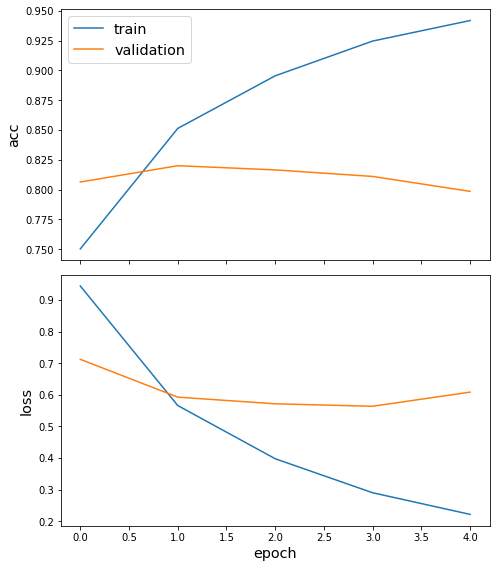

In [ ]:
sg.utils.plot_history(history)

In [ ]:
# We evaluate the best model on our test set
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

52/52 [==============================] - 16s 305ms/step - loss: 0.6119 - acc: 0.7934

Test Set Metrics:
	loss: 0.6119
	acc: 0.7934


### We get a validation accuracy of **79.34% !** Which is better than our previous bert model!

In [ ]:
# We make predictions on a new dataset
all_nodes = data_dic["test"].index
all_mapper = generator.flow(all_nodes)
all_predictions = model.predict(all_mapper)

In [ ]:
# As these data are under the shape of the softmax output layers, we need to inverse_transform function to get them under the shape of original categories.
node_predictions = target_encoding.inverse_transform(all_predictions)
node_predictions

array([0, 1, 0, ..., 2, 2, 0])

In [ ]:
# We download the new predictions under a csv format
from google.colab import files

submit = pd.DataFrame(data=node_predictions , index = data_dic["test"].index, columns = ["label"])
submit.to_csv('Graphsage_1.csv') 
files.download('Graphsage_1.csv')

# Graph Attention Network

In [ ]:
from stellargraph.layer import GAT
from stellargraph.mapper import FullBatchNodeGenerator

In [ ]:
# We use the FullBatchNodeGenerator to feed the node features and the adjency matrix to our keras model.
generator = FullBatchNodeGenerator(G, method="gat")

In [ ]:
train_gen = generator.flow(train_subjects.index, train_targets)

In [ ]:
# We specify our hyperparameters.
# We use a GAT with 2 layers.
# The first layer has 64 dimensional hidden nodes 
# the second layer has 5 class classification output.
# We use 8 attention heads in our GAT.
# We add dropout and attention dropout
gat = GAT(
    layer_sizes=[64, train_targets.shape[1]],
    activations=["relu", "softmax"],
    attn_heads=8,
    generator=generator,
    in_dropout=0.5,
    attn_dropout=0.5,
    normalize=None,
)

In [ ]:
# We create input and output tensor of the GAT model 
x_inp, predictions = gat.in_out_tensors()

In [ ]:
# We create the keras model
model = Model(inputs=x_inp, outputs=predictions)
model.compile(
    optimizer=optimizers.Adamax(lr=0.01),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

In [ ]:
# We will use test_gen to calculate our validation loss anc accuracy
test_gen = generator.flow(test_subjects.index, test_targets)

In [ ]:
# We create callbals for early stopping
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

if not os.path.isdir("logs"):
    os.makedirs("logs")
es_callback = EarlyStopping(
    monitor="val_acc", patience=20
)  # patience is the number of epochs to wait before early stopping in case of no further improvement
mc_callback = ModelCheckpoint(
    "logs/best_model.h5", monitor="val_acc", save_best_only=True, save_weights_only=True
)

In [ ]:
# We train the model
history = model.fit(
    train_gen,
    epochs=300,
    validation_data=test_gen,
    verbose=2,
    shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
    callbacks=[es_callback, mc_callback],
)

Epoch 1/300
1/1 - 1s - loss: 1.6125 - acc: 0.1958 - val_loss: 1.4063 - val_acc: 0.6886
Epoch 2/300
1/1 - 1s - loss: 1.4098 - acc: 0.5737 - val_loss: 1.2023 - val_acc: 0.7414
Epoch 3/300
1/1 - 1s - loss: 1.2490 - acc: 0.6078 - val_loss: 1.0094 - val_acc: 0.7723
Epoch 4/300
1/1 - 1s - loss: 1.1015 - acc: 0.6442 - val_loss: 0.8540 - val_acc: 0.7919
Epoch 5/300
1/1 - 1s - loss: 0.9889 - acc: 0.6739 - val_loss: 0.7451 - val_acc: 0.7985
Epoch 6/300
1/1 - 1s - loss: 0.9137 - acc: 0.6957 - val_loss: 0.6736 - val_acc: 0.8040
Epoch 7/300
1/1 - 1s - loss: 0.8725 - acc: 0.7099 - val_loss: 0.6285 - val_acc: 0.8079
Epoch 8/300
1/1 - 1s - loss: 0.8455 - acc: 0.7095 - val_loss: 0.5971 - val_acc: 0.8091
Epoch 9/300
1/1 - 1s - loss: 0.8297 - acc: 0.7357 - val_loss: 0.5738 - val_acc: 0.8114
Epoch 10/300
1/1 - 1s - loss: 0.8458 - acc: 0.7383 - val_loss: 0.5523 - val_acc: 0.8169
Epoch 11/300
1/1 - 1s - loss: 0.8368 - acc: 0.7327 - val_loss: 0.5372 - val_acc: 0.8220
Epoch 12/300
1/1 - 1s - loss: 0.8121 - ac

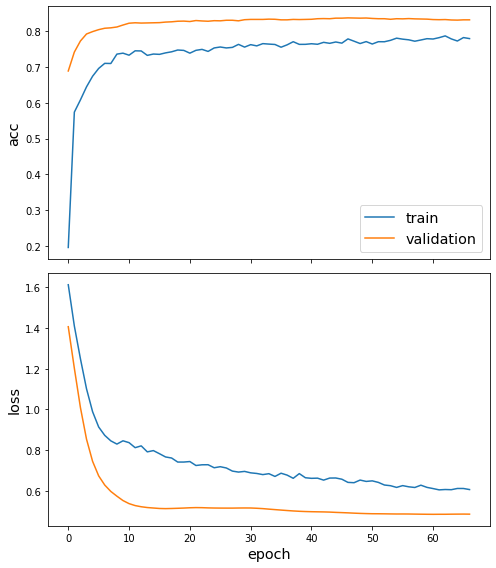

In [ ]:
sg.utils.plot_history(history)


In [ ]:
# We evaluate our best model on our test set
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 2ms/step - loss: 0.4855 - acc: 0.8314

Test Set Metrics:
	loss: 0.4855
	acc: 0.8314


### We get a test accuracy of **83.14% !** Which is better than our previous graphsage model!

In [ ]:
# We make predictions on a new dataset
all_nodes = data_dic["test"].index
all_mapper = generator.flow(all_nodes)
all_predictions = model.predict(all_mapper)

In [ ]:
# As these data are under the shape of the softmax output layers, we need to inverse_transform function to get them under the shape of original categories.
node_predictions = target_encoding.inverse_transform(all_predictions.squeeze())
node_predictions

array([0, 1, 0, ..., 0, 2, 1])

In [ ]:
#We download the new predictions under a csv format
from google.colab import files

submit = pd.DataFrame(data=node_predictions , index = data_dic["test"].index, columns = ["label"])
submit.to_csv('GAT_4.csv') 
files.download('GAT_4.csv')

# Graph Convolutional Network

In [ ]:
from stellargraph.layer import GCN

In [ ]:
# We use the FullBatchNodeGenerator function using the gcn method to put our data under the correct shape for a GCN model.
generator = FullBatchNodeGenerator(G, method="gcn")

Using GCN (local pooling) filters...


In [ ]:
# We create an object forh the generator.flow function with the set of nodes and the true labels that will be used to train the model.
train_gen = generator.flow(train_subjects.index, train_targets)

In [ ]:
# We create a 2 layers GCN with 16 unites per layer.
# We will use the relu activation function for the 2 layers.
# We use a dropout of 0.5
gcn = GCN(
    layer_sizes=[16, 16], activations=["relu", "relu"], generator=generator, dropout=0.5
)

In [ ]:
# We create the input and output tensors that our model will use for its predictions.
x_inp, x_out = gcn.in_out_tensors()

In [ ]:
# The output layer will be a softmax 
predictions = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)

In [ ]:
# We create the keras model
model = Model(inputs=x_inp, outputs=predictions)
model.compile(
    optimizer=optimizers.Adamax(lr=0.01),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

In [ ]:
# We will use test_gen to calculate our validation loss anc accuracy
test_gen = generator.flow(test_subjects.index, test_targets)

In [ ]:
# We will use a callback if validation accuracy stops improving
from tensorflow.keras.callbacks import EarlyStopping

es_callback = EarlyStopping(monitor="val_acc", patience=20, restore_best_weights=True)

In [ ]:
# We train our model
history = model.fit(
    train_gen,
    epochs=300,
    validation_data=test_gen,
    verbose=2,
    shuffle=False, 
    callbacks=[es_callback],
)

Epoch 1/300
1/1 - 1s - loss: 1.6084 - acc: 0.1711 - val_loss: 1.5891 - val_acc: 0.4797
Epoch 2/300
1/1 - 1s - loss: 1.5869 - acc: 0.4306 - val_loss: 1.5622 - val_acc: 0.5305
Epoch 3/300
1/1 - 1s - loss: 1.5612 - acc: 0.4699 - val_loss: 1.5292 - val_acc: 0.5430
Epoch 4/300
1/1 - 1s - loss: 1.5285 - acc: 0.4825 - val_loss: 1.4939 - val_acc: 0.5567
Epoch 5/300
1/1 - 1s - loss: 1.4963 - acc: 0.4940 - val_loss: 1.4573 - val_acc: 0.5634
Epoch 6/300
1/1 - 1s - loss: 1.4625 - acc: 0.5005 - val_loss: 1.4199 - val_acc: 0.5736
Epoch 7/300
1/1 - 1s - loss: 1.4266 - acc: 0.5180 - val_loss: 1.3811 - val_acc: 0.5959
Epoch 8/300
1/1 - 1s - loss: 1.3930 - acc: 0.5325 - val_loss: 1.3408 - val_acc: 0.6205
Epoch 9/300
1/1 - 1s - loss: 1.3537 - acc: 0.5526 - val_loss: 1.2997 - val_acc: 0.6498
Epoch 10/300
1/1 - 1s - loss: 1.3186 - acc: 0.5773 - val_loss: 1.2580 - val_acc: 0.6733
Epoch 11/300
1/1 - 1s - loss: 1.2828 - acc: 0.6070 - val_loss: 1.2157 - val_acc: 0.6941
Epoch 12/300
1/1 - 1s - loss: 1.2434 - ac

In [ ]:
# We evaluate our best model on our test set
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 2ms/step - loss: 0.4783 - acc: 0.8380

Test Set Metrics:
	loss: 0.4783
	acc: 0.8380


### With our GCN model we get a **83.80%** accuracy on the test set! It's performance our a little bit higher than the GAT model and it is now our best model for prediction of labels of scientific research paper.

In [ ]:
# We make predictions on a new dataset
all_nodes = data_dic["test"].index
all_mapper = generator.flow(all_nodes)
all_predictions = model.predict(all_mapper)

In [ ]:
# As these data are under the shape of the softmax output layers, we need to inverse_transform function to get them under the shape of original categories.
node_predictions = target_encoding.inverse_transform(all_predictions.squeeze())
node_predictions

array([0, 1, 0, ..., 2, 2, 1])

In [ ]:
#We download the new predictions under a csv format
from google.colab import files

submit = pd.DataFrame(data=node_predictions , index = data_dic["test"].index, columns = ["label"])
submit.to_csv('GCN_5.csv') 
files.download('GCN_5.csv')